In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.datasets import mnist
import time
from tensorflow.python import debug as tf_debug


Using TensorFlow backend.


In [2]:
(x_trai, y_trai), (x_test, y_test) = mnist.load_data()


In [3]:
#reomve 3000 image of 0,1,2
temp_x=[]
temp_y=[]
count=[0,0,0,0,0,0,0,0]
for i in range(x_trai.shape[0]):
    flag=True
    for j in range(8):
        if j==y_trai[i]:
            if count[j]>=2000:
                flag=False
                break
            count[j]+=1
            break
    if flag:
        temp_x.append(x_trai[i])
        temp_y.append(y_trai[i])
print(len(temp_x))
print(len(temp_y))
print(temp_y.count(1))
x_trai=np.array(temp_x)
y_trai=np.array(temp_y)

27800
27800
2000


In [4]:
y_trai=np.eye(10,dtype=float)[y_trai]
y_test=np.eye(10,dtype=float)[y_test]
x_trai=x_trai/255.0
x_test=x_test/255.0

In [5]:
x_trai.shape

(27800, 28, 28)

In [6]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(x_trai,y_trai,test_size = 0.081,random_state=256)


In [7]:
x_train.shape

(25548, 28, 28)

In [8]:
x_val.shape

(2252, 28, 28)

In [9]:
tf.reset_default_graph()
x = tf.placeholder("float", [None, 28,28])
y_true = tf.placeholder("float", [None, 10])
y_true_cls = tf.argmax(y_true, axis=1)


In [10]:
def new_weights(shape,stddev=0.05):
    return tf.Variable(tf.truncated_normal(shape, stddev=stddev))
def new_biases(length,val=0.05):
    return tf.Variable(tf.constant(val, shape=[length]))

In [11]:
def focal_loss(y_true,y_pred,alpha=0.25,gamma=2):
    zeros = tf.zeros_like(y_pred, dtype=y_pred.dtype)
    pos_p_sub = tf.where(y_true > zeros, y_true - y_pred, zeros)
    neg_p_sub = tf.where(y_true > zeros, zeros, y_pred)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(y_pred, 1e-8, 1.0)) \
- (1 - alpha) * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - y_pred, 1e-8, 1.0))
    return tf.reduce_mean(tf.reduce_sum(per_entry_cross_ent,1))
def focal_loss1(y_true,y_pred,alpha=0.25,gamma=2):
    zeros = tf.zeros_like(y_pred, dtype=y_pred.dtype)
    pos_p_sub = tf.where(y_true > zeros, y_true - y_pred, zeros)
    neg_p_sub = tf.where(y_true > zeros, zeros, y_pred)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(y_pred, 1e-8, 1.0)) \
- (1 - alpha) * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - y_pred, 1e-8, 1.0))
    return per_entry_cross_ent

In [12]:
#First Layer :  6 feature maps or filters having size 5×5 
weight1=new_weights([5,5,1,6])
# Reshape input to 4-D vector
input_layer = tf.reshape(x, [-1, 28, 28, 1]) # -1 adds minibatch support.   
# Padding the input to make it 32x32. Specification of LeNET
padded_input = tf.pad(input_layer, [[0, 0], [2, 2], [2, 2], [0, 0]], "CONSTANT") 
bias1 = new_biases(length=6)
conv_layer1 = tf.nn.conv2d(input=padded_input,
                         filter=weight1,
                         strides=[1, 1, 1, 1],
                         padding='VALID')
conv_layer1 = tf.nn.relu(conv_layer1)
#The resulting image dimensions will be reduced to 28x28x6

#Second Layer: filter size 2×2 and a stride of two
max_pool_layer1 = tf.nn.max_pool(value=conv_layer1,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='VALID')
#The resulting image dimensions will be reduced to 14x14x6


#Third Layer: second convolutional layer with 16 feature maps having size 5×5,
weight2=new_weights([5,5,6,16])
bias2 = new_biases(length=6)
conv_layer2 = tf.nn.conv2d(input=max_pool_layer1,
                         filter=weight2,
                         strides=[1, 1, 1, 1],
                         padding='VALID')
conv_layer2 = tf.nn.relu(conv_layer2)
#The resulting image dimensions will be reduced to 10x10x6

#Fourth Layer:filter size 2×2 and a stride of 2

max_pool_layer2 = tf.nn.max_pool(value=conv_layer2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='VALID')

#The resulting image dimensions will be reduced to 5x5x6

#Fifth Layer: fully connected convolutional layer with 120 feature maps each of size 1×1
layer_shape = max_pool_layer2.get_shape()
num_features = layer_shape[1:4].num_elements()
flatten_layer=tf.reshape(max_pool_layer2, [-1, num_features])
weight3 = new_weights(shape=[400, 120])
bias3 = new_biases(length=120)
fc_layer1=tf.matmul(flatten_layer, weight3) + bias3
fc_layer1 = tf.nn.relu(fc_layer1)

#Sixth Layer:

weight4 = new_weights(shape=[120, 84])
bias4 = new_biases(length=84)
fc_layer2=tf.matmul(fc_layer1, weight4) + bias4
fc_layer2 = tf.nn.relu(fc_layer2)

#Output Layer:

weight5 = new_weights(shape=[84, 10])
bias5 = new_biases(length=10)
output_layer=tf.matmul(fc_layer2, weight5) + bias5
y_pred = tf.nn.softmax(output_layer)
y_pred_cls = tf.argmax(y_pred, axis=1)

In [13]:
#cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=output_layer,labels=y_true)

In [14]:
#cost = tf.reduce_mean(cross_entropy)
cost= focal_loss(y_true,y_pred)
#cost1= focal_loss1(y_true,y_pred)

In [15]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(cost)

In [16]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [17]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [18]:
n_b=0
def next_batch(batch_size):
    remove=batch_size
    global n_b
    n_b+=batch_size
    if n_b>x_train.shape[0]:
        remove=x_train.shape[0]%batch_size
        n_b=x_train.shape[0]
    
    return x_train[n_b-remove:n_b],y_train[n_b-remove:n_b]

In [19]:
session = tf.Session()


In [20]:
session.run(tf.global_variables_initializer())

In [21]:
total_iterations = 0
batch_size=256
num_examples=x_train.shape[0]
def optimize(num_iterations):
    global total_iterations
    global n_b
    total_batch = int(num_examples/batch_size)
    if num_examples%batch_size!=0:
        total_batch+=1
    n_b=0
    for i in range(total_iterations,total_iterations + num_iterations):
        start_time = time.time()
        for j in range(total_batch):
            x_batch, y_true_batch = next_batch(batch_size)
            feed_dict_train = {x: x_batch,y_true: y_true_batch}
            session.run(optimizer, feed_dict=feed_dict_train)
        
        feed_dict_train = {x: x_val,y_true: y_val}
        [acc,loss] = session.run([accuracy,cost], feed_dict=feed_dict_train)
        feed_dict_train = {x: x_train,y_true: y_train}
        [acc1,loss1] = session.run([accuracy,cost], feed_dict=feed_dict_train)
        
        msg = "Optimization Iteration: {0}, Training Accuracy: {1} Training Loss : {2} \n val Accuracy: {3} val Loss : {4}"
        print(msg.format(i + 1, acc1,loss1,acc,loss))
        
        end_time = time.time()
        time_dif = end_time - start_time
        print("Time usage: " + str(time_dif))

In [22]:
optimize(10)

Optimization Iteration: 1, Training Accuracy: 0.942656934261322 Training Loss : 0.03870585560798645 
 val Accuracy: 0.9320604205131531 val Loss : 0.04475202411413193
Time usage: 14.427104234695435
Optimization Iteration: 2, Training Accuracy: 0.9363159537315369 Training Loss : 0.09528791159391403 
 val Accuracy: 0.9316163659095764 val Loss : 0.09830648452043533
Time usage: 12.521311283111572
Optimization Iteration: 3, Training Accuracy: 0.9365116357803345 Training Loss : 0.09789450466632843 
 val Accuracy: 0.932504415512085 val Loss : 0.10046912729740143
Time usage: 12.363555431365967
Optimization Iteration: 4, Training Accuracy: 0.9362376928329468 Training Loss : 0.10029134154319763 
 val Accuracy: 0.9311723113059998 val Loss : 0.10260888934135437
Time usage: 12.423744440078735
Optimization Iteration: 5, Training Accuracy: 0.9361202716827393 Training Loss : 0.10263613611459732 
 val Accuracy: 0.9298401474952698 val Loss : 0.10484199225902557
Time usage: 12.200099229812622
Optimization

## cross_entropy

## Focal loss

In [ ]:
feed_dict_train = {x: x_val[[0,1]],y_true: y_val[[0,1]]}
aaa = session.run(y_pred, feed_dict=feed_dict_train)

In [ ]:
pp= session.run(focal_loss(aaa,y_val[[0,1]]))

In [ ]:
feed_dict_train = {x: x_train,y_true: y_train}
loss = session.run(cost, feed_dict=feed_dict_train)

In [ ]:
new_loss = session.run(tf.reduce_sum(loss,1))

In [ ]:
xyz=[]
for i in loss:
    xyz.append(session.run( tf.reduce_sum(i)))

In [ ]:
mean_loss= session.run(tf.reduce_mean(new_loss))

In [ ]:
loss

# visualisation

In [60]:
image_no=1
feed_dict_train = {x: x_test[[image_no]],y_true: y_test[[image_no]]}
[co1,mx1,co2,mx2] = session.run([conv_layer1,max_pool_layer1,conv_layer2,max_pool_layer2], feed_dict=feed_dict_train)

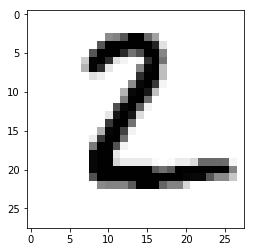

In [61]:
plt.imshow(x_test[image_no], cmap='binary')

In [62]:
print(f'conv 1 : {co1.shape}')
print(f'mx 1 : {mx1.shape}')
print(f'conv 2 : {co2.shape}')
print(f'mx 2 : {mx2.shape}')

conv 1 : (1, 28, 28, 6)
mx 1 : (1, 14, 14, 6)
conv 2 : (1, 10, 10, 16)
mx 2 : (1, 5, 5, 16)


In [63]:
def imgprint(layer,row,col):
    for i in range(layer.shape[-1]):
        plt.subplot(row,col,i+1)
        plt.imshow(layer[0,:,:,i], cmap='binary')

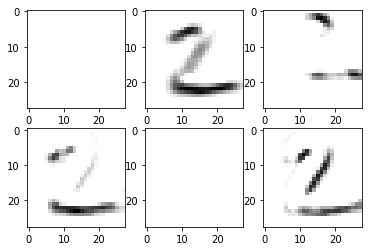

In [64]:
imgprint(co1,2,3)

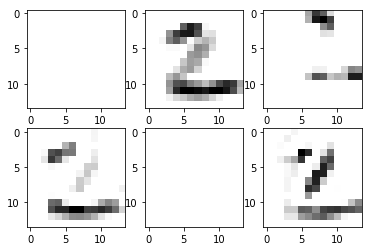

In [65]:
imgprint(mx1,2,3)

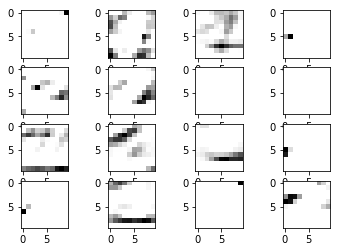

In [66]:
imgprint(co2,4,4)

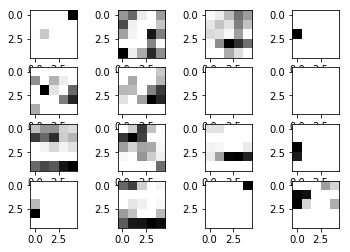

In [67]:
imgprint(mx2,4,4)

In [36]:
ar

array([[[[2, 2, 2],
         [2, 2, 2]],

        [[2, 2, 2],
         [2, 2, 2]]]])